In [287]:
"""Extract a street network given a raster image."""
import json
import sys
from collections import Counter
from dataclasses import dataclass
from typing import List, Tuple

import cv2
import networkx as nx
import numpy as np
import scipy.ndimage.measurements
import shapely.geometry
from PIL import Image
from skimage import morphology, segmentation
import matplotlib.pyplot as plt
import os
import csv
from ast import literal_eval

In [302]:
here = '/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver'
project_name = 'yo'
file_type = 'txt'
nodes_name = f'{project_name}_nodes.{file_type}'
edges_name = f'{project_name}_edges.{file_type}'
detes_name = f'{project_name}_detes.{file_type}'
cycle_name = f'{project_name}_cycle.{file_type}'
os.chdir(here)
os.system('pwd')
os.mkdir(project_name)

/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver


In [206]:
def rgb_to_gray(rgb):
	""" 
        rgb: array of [R, G, B]
        turn rgb array into GRAY array"""
	r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
	gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
	return gray

def two_colors(filename, threshold, other_color):
	'''
		filename: name of png image
		threshold: 
		other_color: that, instead of white (for black-white img)
		RETURN: binary version
		import and then binarize data based on threshold
		'''
	im = Image.open(filename)
	imarray = np.array(im)
	print(f"shape of image array: {np.shape(imarray)}")
	imarray = rgb_to_gray(imarray)
	# apply gaussian filter
	imarray = scipy.ndimage.gaussian_filter(imarray, 0.55)
	print(f"shape of image array, through gaussian filter: {np.shape(imarray)}")
	dim1, dim2 = imarray.shape
	data = np.zeros((dim1, dim2))
	for i in range(dim1):
		for j in range(dim2):
			data[i][j] = 1 - imarray[i][j]
	# normalize
	data += np.abs(np.min(data))
	data = data / np.max(data)
	# turn into binary, by threshold
	largest_dim = max(dim1, dim2)
	binary = np.ones((largest_dim, largest_dim, 3), dtype=int)
	for i in range(dim1):
		for j in range(dim2):
			if data[i][j] > threshold:
				binary[i][j] = other_color
	return binary

In [208]:
""" black-and-other-color image """
filename = 'Arigomphus_villosipes_LHW'
filepath = f'{filename}.png'
BLUE = np.asarray([0, 0, 255])
rgb_binary = two_colors(filepath, 0.025, BLUE)
pil_img = Image.fromarray(rgb_binary.astype('uint8'), "RGB")
pil_img.save("dual_color_blue.png")

shape of image array: (1088, 3001, 4)
shape of image array, through gaussian filter: (1088, 3001)


In [117]:
def find_color(im: Image, rgb: Tuple[int]) -> np.ndarray:
    """Given an RGB image, return an ndarray with 1s where the pixel is the given color."""
    px = np.asarray(im)
    out = np.zeros(im.size, dtype=np.uint8)
    r, g, b = rgb
    out[(px[:, :, 0] == r) & (px[:, :, 1] == g) & (px[:, :, 2] == b)] = 1
    return out


def zhang_suen_node_detection(skel: np.ndarray) -> List[Tuple[int]]:
    """Find nodes based on a skeletonized bitmap.

    (From nefi) Node detection based on criteria put forward in "A fast parallel algorithm
    for thinning digital patterns" by T. Y. Zhang and C. Y. Suen. Pixels p of the skeleton
    are categorized as nodes/non-nodes based on the value of a function A(p) depending on
    the pixel neighborhood of p. Please check the above paper for details.

    A(p1) == 1: The pixel p1 sits at the end of a skeleton line, thus a node
    of degree 1 has been found.
    A(p1) == 2: The pixel p1 sits in the middle of a skeleton line but not at
    a branching point, thus a node of degree 2 has been found. Such nodes are
    ignored and not introduced to the graph.
    A(p1) >= 3: The pixel p1 belongs to a branching point of a skeleton line,
    thus a node of degree >=3 has been found.

    Args:
        *skel* : Skeletonised source image. The skeleton must be exactly 1 pixel wide.

    Returns:
        *nodes* : List of (x, y) coordinates of nodes
    """
    skel = np.pad(skel, 1)
    item = skel.item

    def check_pixel_neighborhood(x, y, skel):
        """
        Check the number of components around a pixel.
        If it is either 1 or more than 3, it is a node.
        """
        p2 = item(x - 1, y)
        p3 = item(x - 1, y + 1)
        p4 = item(x, y + 1)
        p5 = item(x + 1, y + 1)
        p6 = item(x + 1, y)
        p7 = item(x + 1, y - 1)
        p8 = item(x, y - 1)
        p9 = item(x - 1, y - 1)

        # The function A(p1),
        # where p1 is the pixel whose neighborhood is beeing checked
        components = (
            (p2 == 0 and p3 == 1)
            + (p3 == 0 and p4 == 1)
            + (p4 == 0 and p5 == 1)
            + (p5 == 0 and p6 == 1)
            + (p6 == 0 and p7 == 1)
            + (p7 == 0 and p8 == 1)
            + (p8 == 0 and p9 == 1)
            + (p9 == 0 and p2 == 1)
        )
        return (components >= 3) or (components == 1)

    nodes = []
    w, h = skel.shape
    for x in range(1, w - 1):
        for y in range(1, h - 1):
            if item(x, y) != 0 and check_pixel_neighborhood(x, y, skel):
                nodes.append((x - 1, y - 1))
    return nodes


def find_dense_skeleton_nodes(skel: np.ndarray) -> List[Tuple[int, int]]:
    """Find "dense" (2x2 or larger) regions in the skeleton."""
    eroded = morphology.binary_erosion(np.pad(skel, 1), np.ones((2, 2)))[1:-1, 1:-1]

    # Find the centers of mass of connected components
    labeled_array, num_features = scipy.ndimage.label(eroded)
    centers = scipy.ndimage.center_of_mass(eroded, labeled_array, [*range(1, num_features+1)])
    return [(int(x), int(y)) for (x, y) in centers]


def add_dense_nodes(nodes: List[Tuple[int, int]], dense_nodes: List[Tuple[int, int]], min_distance = 5) -> List[Tuple[int, int]]:
    """Add in new nodes which are distinct from the old ones."""
    keep = []
    min_d2 = min_distance ** 2
    for node in dense_nodes:
        x, y = node
        is_ok = True
        for nx, ny in nodes:
            d2 = (x - nx) **2 + (y - ny) ** 2
            if d2 < min_d2:
                is_ok = False
                break
        if is_ok:
            keep.append(node)

    print(f'Adding {len(keep)}/{len(dense_nodes)} dense nodes to existing {len(nodes)} nodes.')
    return [*nodes, *keep]


@dataclass
class Path:
    """ @dataclass
        start: 2D coordinate <- starting node
        end: 2D coordinate <- ending node
        path: list of 2D coordinates <- nodes on path
        """
    start: Tuple[int, int]
    stop: Tuple[int, int]
    path: List[Tuple[int, int]]


def is_new_path(existing_paths: List[Path], path: Path) -> bool:
    """ 
        existing_paths: paths so far
        path: need to test if this is in existing_path
        Is this a new path, or does it overlap signficantly with existing paths?"""
    candidates = [p for p in existing_paths if p.start == path.start and p.stop == path.stop]
    other_points = {coord for p in candidates for coord in p.path[1:-1]}
    interior = set(path.path[1:-1])
    if other_points & interior:
        return False
    return True


def is_valid_self_loop(path: List[Tuple[int, int]], min_self_loop_distance: int) -> bool:
    if len(path) < min_self_loop_distance:
        return False
    # Only the end node can appear twice in a self-loop
    return len([c for c, n in Counter(path).items() if n >= 2]) == 1


def find_paths(scikit_img_skeleton: np.ndarray, nodes: List[Tuple[int]], min_distance=5) -> List[Path]:
    """Find paths between nodes in the graph using the connectivity in the skeleton.
    RETURN: list of edges (pairs of nodes) with the following properties.
        - path: list of coordinates connecting the nodes (including the nodes)
        - d: length of the path
    This will early-out if a path shorter than min_distance is found.
    There may be multiple distinct paths between the same nodes, or a path between a node and itself.
    """
    width, height = scikit_img_skeleton.shape
    def neighbors(x, y):
        for dy in (-1, 0, 1):
            cy = y + dy
            if cy < 0 or cy >= height:
                continue
            for dx in (-1, 0, 1):
                cx = x + dx
                if (dx != 0 or dy != 0) and 0 <= cx < width and scikit_img_skeleton[cx, cy]:
                    yield cx, cy
    # each cell points back to its parent
    parents = {n: None for n in nodes}
    def trace_back(node):
        trace = []
        while node:
            trace.append(node)
            node = parents.get(node)
        return trace
    d = {n: 0 for n in nodes}  # used to avoid backtracking
    edges = []
    frontier = [*nodes]
    while frontier:
        next_frontier = []
        for n in frontier:
            x, y = n
            for c in neighbors(x, y):
                if c not in parents:
                    parents[c] = n
                    next_frontier.append(c)
                    d[c] = 1 + d[n]
                else:
                    if d[c] >= d[n]:
                        # we've got a connection! Follow both cells back to trace it out
                        tn = trace_back(n)
                        tc = trace_back(c)
                        tc.reverse()
                        path = [*tc, *tn]
                        endpoints = (path[0], path[-1])
                        start, stop = min(endpoints), max(endpoints)
                        new_path = Path(start, stop, path)
                        # Ignore redundant paths and short self-loops
                        if is_new_path(edges, new_path) and (
                            start != stop or is_valid_self_loop(path, min_distance)
                        ):
                            edges.append(new_path)
                            if len(path) - 1 < min_distance:
                                # This edge will get pruned out anyway, so no need to keep looking.
                                return edges
        frontier = next_frontier
    return edges


def merge_nodes(
    nodes: List[Tuple[int, int]], edges: List[Path], n1: Tuple[int, int], n2: Tuple[int, int]
    ) -> List[Tuple[int, int]]:
    ends = {n1, n2}
    paths = [e.path for e in edges if {e.start, e.stop} == ends]
    assert paths
    path = min(paths, key=lambda p: len(p))
    idx = len(path) // 2
    new_node = path[idx]
    return [new_node] + [n for n in nodes if n != n1 and n != n2]


def make_graph(nodes: List[Tuple[int, int]], edges: List[Path]) -> nx.MultiGraph:
    g = nx.MultiGraph()
    g.add_nodes_from(nodes)
    for edge in edges:
        g.add_edge(edge.start, edge.stop, path=edge.path, d=len(edge.path) - 1)
    return g


def connect_graph(skel: np.ndarray, min_distance: int) -> nx.MultiGraph:
    """Iteratively produce a graph, merging nodes until none are < min_distance apart."""
    nodes = zhang_suen_node_detection(skel)
    dense_nodes = find_dense_skeleton_nodes(skel)
    nodes = add_dense_nodes(nodes, dense_nodes)
    edges = find_paths(skel, nodes, min_distance)
    any_changed = True
    while any_changed:
        any_changed = False
        for edge in edges:
            d = len(edge.path) - 1
            if d < min_distance:
                n1 = edge.start
                n2 = edge.stop
                nodes = merge_nodes(nodes, edges, n1, n2)
                edges = find_paths(skel, nodes, min_distance)
                # print(f'Merged {n1} and {n2}, d={d}')
                any_changed = True
                break
    # All good!
    return make_graph(nodes, edges)


def simplify_paths(g: nx.Graph, tolerance=1) -> nx.Graph:
    for n1, n2, k in g.edges(keys=True):
        g[n1][n2][k]['path'] = shapely.geometry.LineString(g[n1][n2][k]['path']).simplify(tolerance)
    return g


def extract_network(mask: np.ndarray, min_distance=8) -> nx.Graph:
    """ given mask, return graph network
        """
    # see https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html
    skel = morphology.skeletonize(mask)
    print(f'Skeleton px={skel.sum()}')
    raw = connect_graph(skel, min_distance)
    simplified = simplify_paths(raw)
    return simplified, raw


def create_circular_mask(shape, center, radius):
    w, h = shape
    cx, cy = center
    X, Y = np.ogrid[:w, :h]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    mask = dist_from_center <= radius
    return mask


def render_network(im: Image, graph: nx.Graph, rgb: Tuple[int]) -> Image:
    """Produce a rendering of the extracted street network on top of the image.

    Streets (nodes and edges) are colored rgb.
    """
    r, g, b = rgb
    px = np.asarray(im).copy()

    for x, y in graph.nodes():
        circle = create_circular_mask(px.shape[0:2], (y, x), 4).astype(np.uint8)
        # clean this up
        px[:, :, 0] += r * circle
        px[:, :, 1] += g * circle
        px[:, :, 2] += b * circle

    for (n1, n2, k) in graph.edges(keys=True):
        path = graph[n1][n2][k]['path']
        for pt1, pt2 in zip([*path.coords][:-1], [*path.coords][1:]):
            y1, x1 = pt1
            y2, x2 = pt2
            cv2.line(px, (int(y1), int(x1)), (int(y2), int(x2)), color=rgb, thickness=1)
        for (x, y) in path.coords:
            circle = create_circular_mask(px.shape[0:2], (y, x), 2).astype(np.uint8)
            px[:, :, 0] += r * circle
            px[:, :, 1] += g * circle
            px[:, :, 2] += b * circle
    return Image.fromarray(px)

def render_skeleton(im: Image, skel: np.ndarray, rgb: Tuple[int]) -> Image:
    r, g, b = rgb
    px = np.asarray(im).copy()
    skel = skel.T
    px[skel > 0, 0] = r
    px[skel > 0, 1] = g
    px[skel > 0, 2] = b
    return Image.fromarray(px)

# Sum of the min & max of (a, b, c)
def hilo(a, b, c):
    if c < b:
        b, c = c, b
    if b < a:
        a, b = b, a
    if c < b:
        b, c = c, b
    return a + c


def complement(rgb):
    """Return a complementary color; see https://stackoverflow.com/a/40234924/388951"""
    k = hilo(*rgb)
    return tuple(k - u for u in rgb)


def network_to_geojson(g: nx.Graph):
    return {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'id': f'street-{i}',
                'properties': {
                    'street': i,
                    'len': (e := g[n1][n2][k])['d'],
                    'start': (coords := e['path'].coords)[0],
                    'stop': coords[-1],
                },
                'geometry': [*coords],
            }
            for i, (n1, n2, k) in enumerate(g.edges(keys=True))
        ],
    }

In [118]:
png_file = 'dual_color_b.png'
street_color_in_rgb = tuple([0, 0, 255])

img = Image.open(png_file)
mask = find_color(img, street_color_in_rgb).T # yes = 1; no = 0

print(f'Street RGB: \t{street_color_in_rgb}')
print(f'Street pixels: \t{mask.sum()}')
network, raw = extract_network(mask)
print(f'Extracted street network:')
print(f'  - {len(network.nodes())} nodes')
print(f'  - {len(network.edges())} edges')

skel = morphology.skeletonize(mask)
skel_path = png_file.replace('.png', '.skel.png')
render_skeleton(img, skel, complement(street_color_in_rgb)).save(skel_path)
print(f'Wrote {skel_path}')

out_path = png_file.replace('.png', '.grid.png')
render_network(img, network, complement(street_color_in_rgb)).save(out_path)
print(f'Wrote {out_path}')

fc = network_to_geojson(network)
# geojson_path = png_file.replace('.png', '.grid.geojson') # <- dont need
# with open(geojson_path, 'w') as out:
#     json.dump(fc, out)
# print(f'Wrote {geojson_path}')

Street RGB: 	(0, 0, 255)
Street pixels: 	324071
Skeleton px=58348
Adding 5/5 dense nodes to existing 1079 nodes.
Extracted street network:
  - 1002 nodes
  - 1496 edges
Wrote dual_color_b.skel.png
Wrote dual_color_b.grid.png


In [119]:
# edge_count = 0
# print(f"is this network directed? {network.is_directed()}")
# # this LOOKS liks directed, but every edge is DOUBLE edge!
# for edge in network.edges():
#     # print(edge)
#     # print(f"start: {edge[0]}, \tend {edge[1]}")
#     edge_count += 1
# # print(f"number of edges: {edge_count}")

In [120]:
# def addEdge(u, v, g):
# 	g[u].append(v)
# 	g[v].append(u)

In [121]:
# def dfs_cycle(start_vertex, previous_vertex, color, parents, graph):
# 	"""	
# 		current_vertex: we're on this vertex now
# 		previous_vertex: we got to current_vertex FROM previous_vertex
# 		color: 2 = complete visited; 1 = incomplete visited; 0 = just found
# 		parents: parents of all vertices"""
# 	global cyclenumber # exist outside the function
# 	global list_of_all_cycles
# 	if color[start_vertex] == 2: # already (completely) visited vertex.
# 		return
# 	# seen vertex, but was not completely visited -> cycle detected.
# 	# backtrack based on parents to find the complete cycle.
# 	if color[start_vertex] == 1:
# 		path = []
# 		current = previous_vertex
# 		path.append(current)
# 		# backtrack the vertex in the current cycle thats found
# 		while current != start_vertex:
# 			current = parents[current]
# 			path.append(current)
# 		list_of_all_cycles.append(path)
# 		cyclenumber += 1
# 		return
# 	parents[start_vertex] = previous_vertex
# 	color[start_vertex] = 1 # if ur here, this vertex is just found -> imcomp visited
# 	# simple dfs on graph
# 	neighbors = graph[start_vertex]
# 	for v in neighbors:
# 		# if it has not been visited previously
# 		if v == parents[start_vertex]:
# 			continue
# 		dfs_cycle(v, start_vertex, color, parents, graph)
# 	# completely visited this vertex
# 	color[start_vertex] = 2
# def printCycles():
# 	for i in range(0, cyclenumber):
# 		print("Cycle Number %d:" % (i + 1), end = " ")
# 		for x in list_of_all_cycles[i]:
# 			print(x, end = " ")
# 		print()

In [122]:
# number_of_nodes = len(network.nodes())
# list_of_nodes = list(network.nodes())
# q = [[] for i in range(number_of_nodes + 2)]
# for edge in network.edges():
#     u = edge[0]
#     v = edge[1]
#     addEdge(list_of_nodes.index(u), list_of_nodes.index(v), q)
# q

In [123]:
# color = [0] * (number_of_nodes + 2) # <- N is number of nodes
# parents = [0] * (number_of_nodes + 2)
# # store the numbers of cycle
# cyclenumber = 0
# list_of_all_cycles = []
# dfs_cycle(1, 0, color, parents, q)
# printCycles()
# list_of_all_cycles

In [124]:
# closed_cycles_edges_index = []
# for cycle in list_of_all_cycles:
#     list_of_edges_of_this_cycle = []
#     for i in range(len(cycle)): # 'cycle' here NO include repeate node!
#         edge_u_index = i
#         edge_v_index = i + 1
#         if(edge_v_index > len(cycle) - 1):
#             edge_v_index = 0 # last indes in cycle connects to first index, hence closing the cycle
#         list_of_edges_of_this_cycle.append((cycle[edge_u_index], cycle[edge_v_index]))
#     closed_cycles_edges_index.append(list_of_edges_of_this_cycle)
# # closed_cycles_edges_index

In [125]:
# combinations = [(a, b) for idx, a in enumerate(best_cycles) for b in best_cycles[idx:]]
# len(combinations)

In [303]:
number_of_nodes = len(network.nodes())
list_of_nodes = list(network.nodes())
number_of_edges = len(network.edges())
"""storage"""
edges_array = np.zeros(shape=(number_of_edges, 2))
G = nx.Graph()
index = 0
list_of_details = []
for edge in network.edges(data=True):
    # print(edge)
    x, y, path = edge
    # print(f"path: {path}")
    path_object = path['path']
    coords = [*path_object.coords]
    # coords = [str(coord) for coord in coords]
    # coords_comma_separated_string = ",".join(coords)
    # list_of_details.append([coords_comma_separated_string])
    list_of_details.append(coords)
    # print(f"coords: {[*path_object.coords]}")
    x_index = list_of_nodes.index(x)
    y_index = list_of_nodes.index(y)
    edges_array[index] = np.asarray([x_index, y_index])
    # print(edges_array[index])
    nx.add_path(G, [x_index, y_index])
    index += 1
    # if index > 1:
    #     break
print(f"G's number of nodes: {number_of_nodes}")
print(f"G's number of edges: {number_of_edges}")
print(f"G is directed? {G.is_directed()}")

G's number of nodes: 1002
G's number of edges: 1496
G is directed? False


In [ ]:
# e = [(1, 2.0), (3, 4)]
# e_string = [str(t) for t in e]
# # s = ''
# # for pair in e:
# #     s += str(pair) + 
# s = ",".join(e_string)
# print(f"s: {s}")
# l = literal_eval(s)
# [*l]

In [318]:
os.chdir(here)
os.system('pwd')
os.chdir(project_name)
os.system('pwd')
"""save the nodes"""
nodes_array = np.zeros(shape=(number_of_nodes, 2))
for i in range(number_of_nodes):
    a_node_in_array = np.asarray(list_of_nodes[i])
    nodes_array[i] = a_node_in_array   
np.savetxt(fname=nodes_name, X=nodes_array, fmt='%i') 
# print(node_array[10])
# print(list_of_nodes[10])
"""save the edges: indices""" 
np.savetxt(fname=edges_name, X=edges_array, fmt='%i')
os.system('pwd')
"""save the cycle: indices"""
with open(detes_name, 'w') as f:
    writer = csv.writer(f) # remove quote for string
    writer.writerows(list_of_details) # NOT writerow()

/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver
/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver/yo
/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver/yo


In [ ]:
"""calculate minimum cycle basis"""
print("running nx.minimum_cycle_basis()")
cycles = nx.minimum_cycle_basis(G)
print(f"found {len(cycles)} cycles")

In [242]:
# print(G.nodes())
# best_result = 20000 # need manual adjust atm!
# best_cycles = None
# cycles_to_keep = set([])
# for node in G.nodes(): 
#     cycles = nx.minimum_cycle_basis(G, node)
#     flattened_cycle = [node for cycle in cycles for node in cycle]
#     current_result = len(flattened_cycle)
#     # cycle_lengths = [len(cycle) for cycle in cycles]
#     # average_length = np.median(cycle_lengths)
#     # current_result = average_length
#     # print(f"currently, node: {node}, best: {best_result}, now: {current_result}")
#     if current_result <= best_result:
#         best_cycles = cycles
#         best_result = current_result
# print(f"number of cycles: {len(best_cycles)}")
# print(f"number of nodes: {number_of_nodes}")
# print(f"best_result: {best_result}")
# print(f"check: {len([node for cycle in best_cycles for node in cycle])}")
# for cycle in best_cycles:
#     print(cycle)

"""sort cycles"""
sorted_cycles = []
for cycle in cycles:
    sorted_cycle = []
    real_edges = []
    combinations = [(a, b) for index, a in enumerate(cycle) for b in cycle[index + 1:]]
    for (a, b) in combinations:
        if (a, b) in G.edges():
            real_edges.append((a, b))
    # print(f"real edges: {real_edges}")
    arbitraty_start = real_edges[0][0]
    sorted_cycle.append(arbitraty_start)
    # print(f"sorted cycle start: {sorted_cycle}")
    for i in range(len(cycle)):
        for a, b in real_edges:
            if a == sorted_cycle[-1] and b not in sorted_cycle:
                sorted_cycle.append(b)
                continue
            if b == sorted_cycle[-1] and a not in sorted_cycle:
                sorted_cycle.append(a)
                continue
    sorted_cycle = sorted_cycle[:len(sorted_cycle)]
    sorted_cycles.append(sorted_cycle)
    # print(f"{cycle} -> {sorted_cycle}")
cycles = sorted_cycles

In [310]:
os.system('pwd')
"""save the cycle: indices & sorted to follow actual edges"""
with open(cycle_name, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(cycles) # NOT writerow()

/Users/kronos.di.vlad/Desktop/dragonfly/extract_images_nb_ver/yo


In [329]:
file = open(cycle_name, "r")
data = list(csv.reader(file, delimiter=",", quoting = csv.QUOTE_NONNUMERIC))
for i in range(len(data)):
    data[i] = [int(item) for item in data[i]]

In [334]:
file = open(detes_name, "r")
data = list(csv.reader(file, delimiter=",", quoting = csv.QUOTE_NONNUMERIC))
for i in range(len(data)):
    data[i] = [literal_eval(item) for item in data[i]]
data

[[(2890.0, 355.0),
  (2894.0, 360.0),
  (2898.0, 362.0),
  (2901.0, 366.0),
  (2902.0, 371.0)],
 [(2878.0, 374.0),
  (2880.0, 374.0),
  (2885.0, 369.0),
  (2892.0, 359.0),
  (2890.0, 355.0)],
 [(2869.0, 333.0),
  (2873.0, 334.0),
  (2883.0, 344.0),
  (2886.0, 351.0),
  (2890.0, 355.0)],
 [(2890.0, 355.0),
  (2887.0, 352.0),
  (2884.0, 355.0),
  (2874.0, 356.0),
  (2864.0, 360.0)],
 [(2866.0, 467.0), (2868.0, 470.0), (2875.0, 470.0), (2878.0, 473.0)],
 [(2878.0, 473.0), (2881.0, 475.0), (2902.0, 476.0)],
 [(2892.0, 497.0), (2882.0, 476.0), (2878.0, 473.0)],
 [(2878.0, 473.0), (2876.0, 471.0), (2877.0, 467.0), (2893.0, 443.0)],
 [(2819.0, 369.0),
  (2821.0, 373.0),
  (2827.0, 375.0),
  (2830.0, 378.0),
  (2835.0, 379.0)],
 [(2819.0, 369.0),
  (2818.0, 366.0),
  (2812.0, 364.0),
  (2799.0, 354.0),
  (2795.0, 353.0),
  (2794.0, 351.0)],
 [(2798.0, 396.0),
  (2802.0, 394.0),
  (2816.0, 379.0),
  (2820.0, 373.0),
  (2819.0, 369.0)],
 [(2819.0, 369.0),
  (2818.0, 366.0),
  (2822.0, 361.0),
  

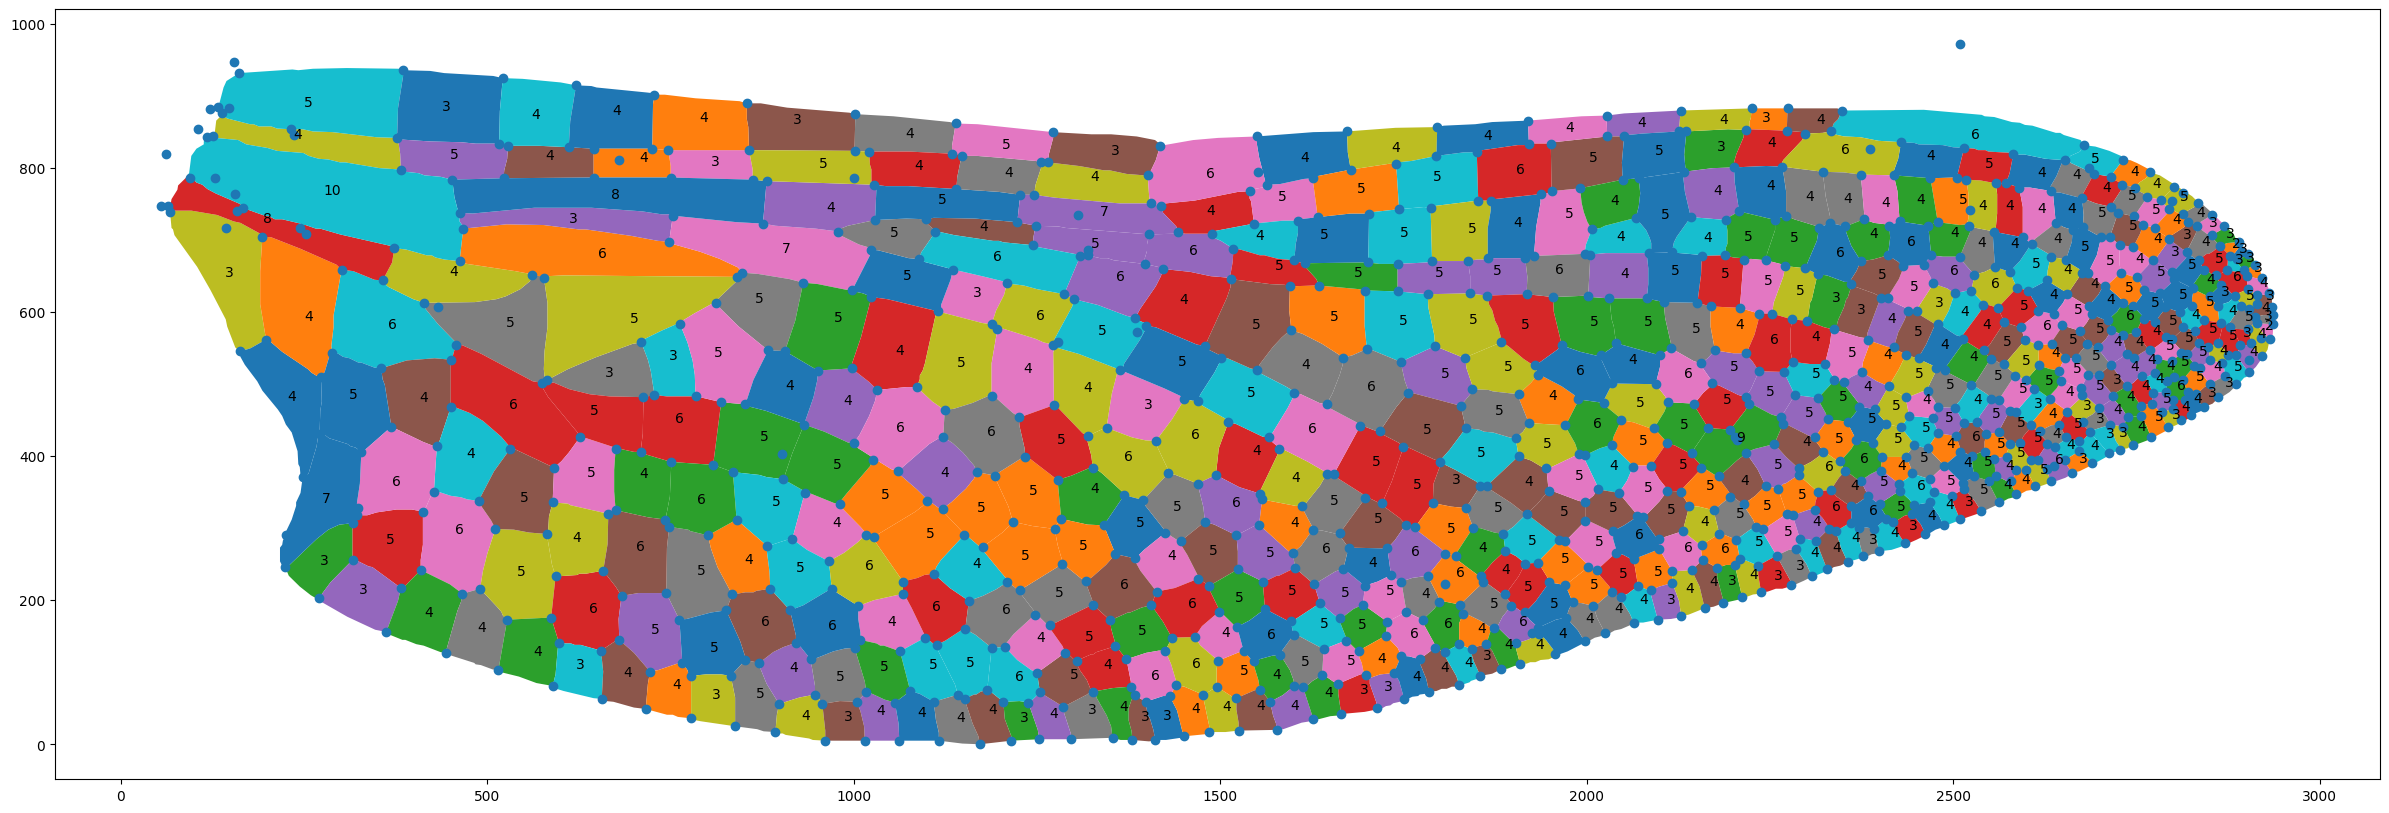

In [244]:
"""plot results"""
all_x_coords = []
all_y_coords = []
for node in list_of_nodes:
    x = node[0]
    y = node[1]
    all_x_coords.append(x)
    all_y_coords.append(y)
y_maximum = max(all_y_coords)
x_coords = []
y_coords = []
def plot_edge(network):
    counter = 0
    list_of_edges = list(network.edges())
    for edge in list_of_edges:
        u, v = edge
        x_this_edge = [u[0], v[0]]
        y_this_edge = [u[1], v[1]]
        midpoint_x = np.mean(x_this_edge)
        midpoint_y = np.mean(y_this_edge)
        plt.plot(x_this_edge,
                [y * -1 + y_maximum for y in y_this_edge],
                '-', scalex=10, scaley=10)
        plt.annotate(counter, (midpoint_x, midpoint_y * -1 + y_maximum))
        counter += 1
def plot_cycle_edge_all(network, cycles, detail_level, detail_type, centroid):
    for i in range(len(cycles)):
        if(detail_level == "low"):
            plot_cycle_edge(cycles, i, detail_type, centroid)
        else:
            plot_cycle_edge_detailed(network, cycles, i, detail_type, centroid)
        
def plot_cycle_edge(cycles, i, setting, centroid):
    # print(f"cycle no. {i}: {cycles[i]}")
    cycle = cycles[i]
    x_coords = []
    y_coords = []
    for i in range(len(cycle)):
        u = cycle[i]
        u_node = list_of_nodes[u]
        x_coords.append(u_node[0])
        y_coords.append(u_node[1])
    start = list_of_nodes[cycle[0]]
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    x_coords.append(start[0])
    y_coords.append(start[1])
    if(setting == "lines"):
        plt.plot(x_coords, 
                [y * -1 + y_maximum for y in y_coords], 
                '-', scalex=10, scaley=10)
    if(setting == "fill"):
        plt.fill(x_coords, 
                [y * -1 + y_maximum for y in y_coords], 
                )
    if(centroid == True):
        plt.annotate(i, (centroid_x, centroid_y * -1 + y_maximum))
    return len(x_coords) - 1
def plot_cycle_edge_detailed(network, cycles, i, setting, centroid):
    # print(f"cycle no. {i}: {cycles[i]}")
    cycle = cycles[i]
    x_coords = []
    y_coords = []
    for i in range(len(cycle)):
        u = cycle[i]
        if(i + 1) > len(cycle) - 1:
            v = cycle[0]
        else:
            v = cycle[i + 1]
        # starting node
        u_node = list_of_nodes[u] 
        v_node = list_of_nodes[v]
        x_coords.append(u_node[0])
        y_coords.append(u_node[1])
        # middle nodes
        path = network[u_node][v_node][0]['path'] # <- how the code works
        coordinates = [*path.coords]
        start = coordinates[0] # <- paths here are 'directed'!
        end = coordinates[1]
        if(u_node == start):
            pass
        else:
            coordinates.reverse()
        # ditch the start & middle elements of the list!
        intermediary_coordinates = coordinates[1:len(coordinates) - 1]
        for x, y in intermediary_coordinates:
            x_coords.append(x)
            y_coords.append(y)
        # ending node 
        x_coords.append(v_node[0])
        y_coords.append(v_node[1])
        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
    if(setting == "lines"):
        plt.plot(x_coords, 
                [y * -1 + y_maximum for y in y_coords], 
                '-', scalex=10, scaley=10)
    if(setting == "fill"):
        plt.fill(x_coords, 
                [y * -1 + y_maximum for y in y_coords], 
                )
    if(centroid == True):
        plt.annotate(i, (centroid_x, centroid_y * -1 + y_maximum))

plt.figure(figsize=(30, 10))
plt.plot(all_x_coords, 
         [y * -1 + y_maximum for y in all_y_coords], 
         'o', scalex=10, scaley=10)
plot_cycle_edge_all(network, cycles, "hi", "fill", True)
# _, _, cycle_length = plot_cycle_edge(network, best_cycles, 8) # <- problem cycle
# cycle_length
# plot_edge(network)
# for i in range(number_of_nodes):
#     plt.annotate(i, (all_x_coords[i], all_y_coords[i] * -1 + y_maximum))
# [52, 56, 40, 46]

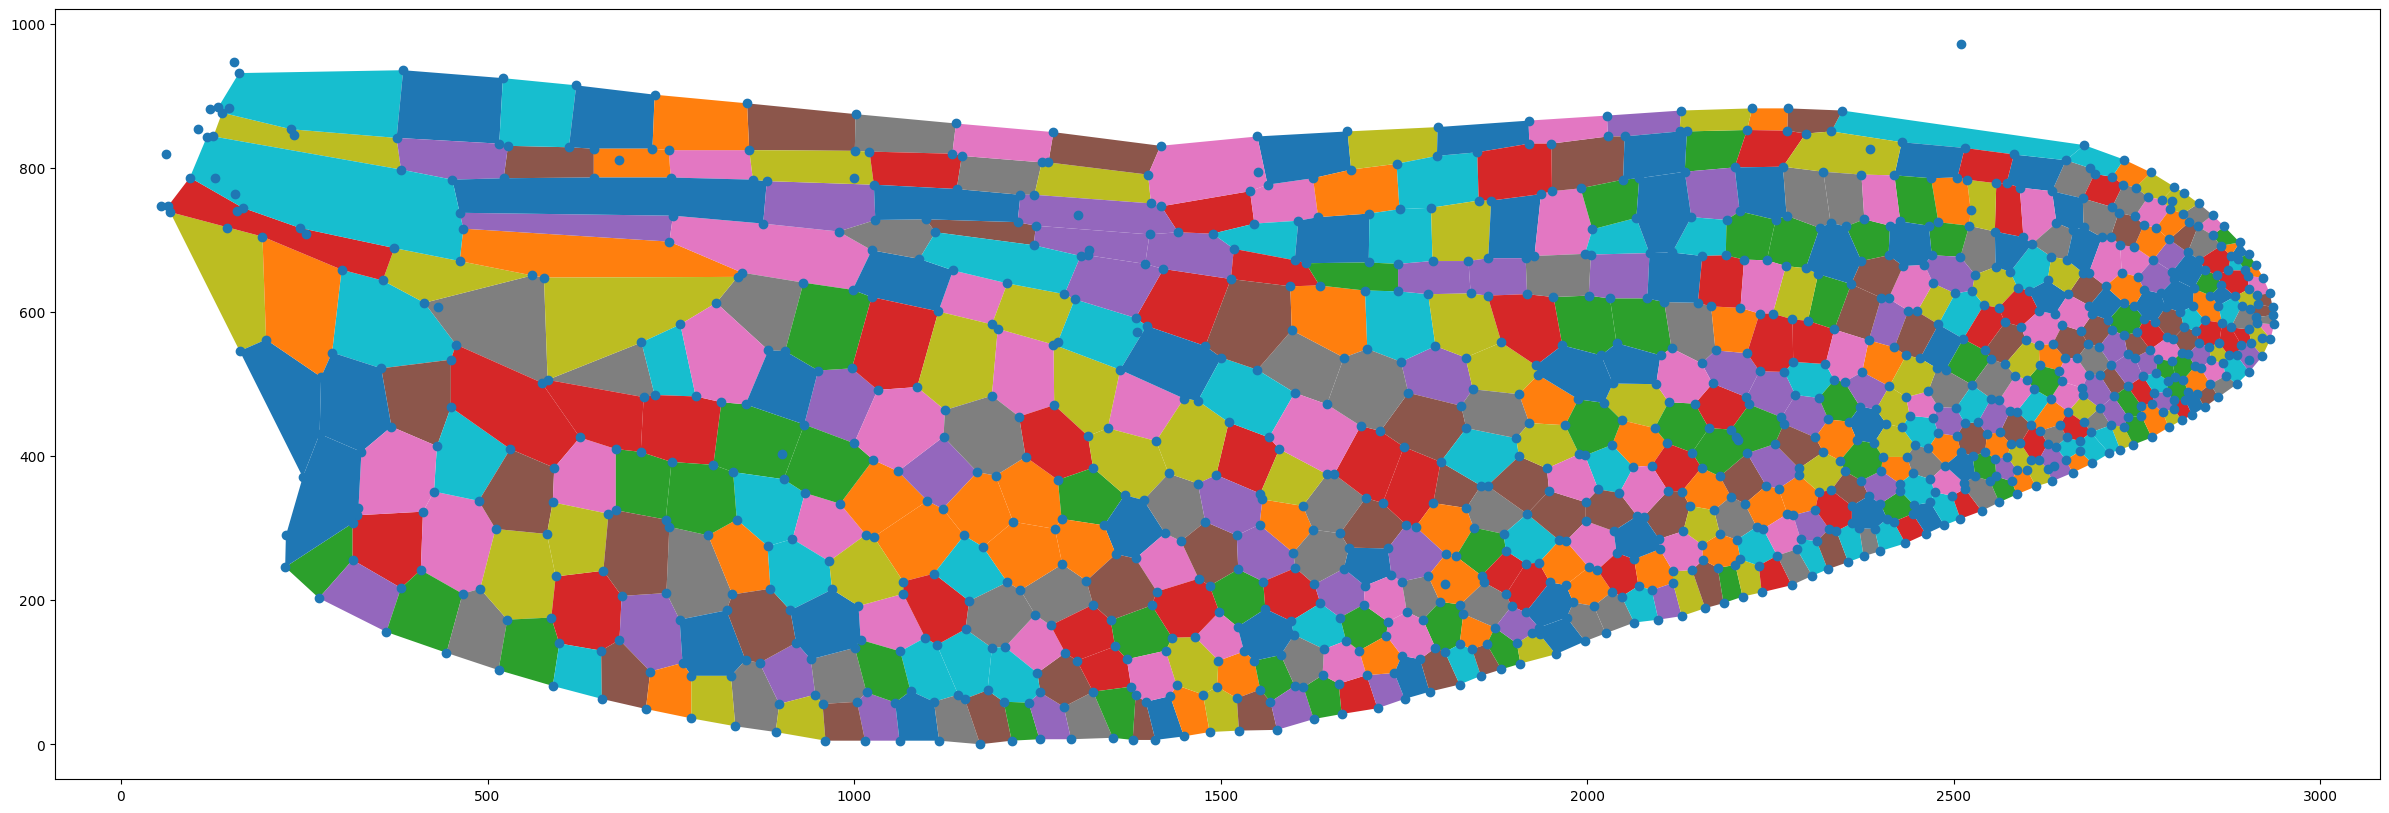

In [150]:
plt.figure(figsize=(30, 10))
plt.plot(all_x_coords, 
         [y * -1 + y_maximum for y in all_y_coords], 
         'o', scalex=10, scaley=10)
for i in range(len(cycles)):
    plot_cycle_edge(network, cycles, i)

In [156]:
import drawsvg as draw
def draw_line(stt_x, stt_y, end_x, end_y, color='orange'):
    return draw.Line(stt_x, stt_y, end_x, end_y, cw=True, stroke=color, stroke_width=1)
def draw_arc(radius, degree_start, degree_end, color='yellow'):
    return draw.Arc(0, 0, radius, degree_start, degree_end, 
             cw=True, stroke=color, stroke_width=1, fill='none')
def text(text, x_position, y_position):
    return draw.Text(text=text, font_size=12, x=x_position, y=y_position, fill='green', center=True)
import math
def rotate_cartesian(origin, x, y, angle_degrees):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    if origin == None:
        origin = (0, 0)
    ox, oy = origin
    angle = math.radians(angle_degrees)
    qx = ox + math.cos(angle) * (x - ox) - math.sin(angle) * (y - oy)
    qy = oy + math.sin(angle) * (x - ox) + math.cos(angle) * (y - oy)
    return qx, qy

In [203]:
def draw_cycle_edge_detailed(network, cycles, i, canvas):
    # print(f"cycle no. {i}: {cycles[i]}")
    cycle = cycles[i]
    x_coords = []
    y_coords = []
    for i in range(len(cycle)):
        u = cycle[i]
        if(i + 1) > len(cycle) - 1:
            v = cycle[0]
        else:
            v = cycle[i + 1]
        # starting node
        u_node = list_of_nodes[u] 
        v_node = list_of_nodes[v]
        x_coords.append(u_node[0])
        y_coords.append(u_node[1])
        # middle nodes
        path = network[u_node][v_node][0]['path'] # <- how the code works
        coordinates = [*path.coords]
        start = coordinates[0] # <- paths here are 'directed'!
        end = coordinates[1]
        if(u_node == start):
            pass
        else:
            coordinates.reverse()
        # ditch the start & middle elements of the list!
        intermediary_coordinates = coordinates[1:len(coordinates) - 1]
        for x, y in intermediary_coordinates:
            x_coords.append(x)
            y_coords.append(y)
        # ending node 
        # x_coords.append(v_node[0])
        # y_coords.append(v_node[1])
        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
    # for pair in zip(x_coords, y_coords):
    #     print(pair)
    coords = [a for b in zip(x_coords, y_coords) for a in b]
    canvas.append(draw.Lines(*coords,
                   fill='none', stroke='yellow', close='true'))
def draw_cycle_edge(cycles, i, canvas):
    # print(f"cycle no. {i}: {cycles[i]}")
    cycle = cycles[i]
    x_coords = []
    y_coords = []
    for i in range(len(cycle)):
        u = cycle[i]
        u_node = list_of_nodes[u]
        x_coords.append(u_node[0])
        y_coords.append(u_node[1])
    # start = list_of_nodes[cycle[0]]
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    # x_coords.append(start[0])
    # y_coords.append(start[1])
    coords = [a for b in zip(x_coords, y_coords) for a in b]
    canvas.append(draw.Lines(*coords,
                   fill='none', stroke='yellow', close='true'))
    
def draw_cycle_edge_all(network, cycles, canvas, detail_level):
    for i in range(len(cycles)):
        if(detail_level == "low"):
            draw_cycle_edge(cycles, i, canvas)
        else:
            draw_cycle_edge_detailed(network, cycles, i, canvas)

In [172]:
x_coords = [0, 55, 45, 5]
y_coords = [10, 10, 20, 20]
input = [a for b in zip(x_coords, y_coords) for a in b]
input

[0, 10, 55, 10, 45, 20, 5, 20]

In [205]:
c = draw.Drawing(3000, 1000, origin='top-left')
# polygon = draw.Lines(0, 10, 55, 10, 45, 20, 5, 20,
#                    fill='none', stroke='yellow', close='true')
# polygon = draw.Lines(*input,
#                    fill='none', stroke='yellow', close='true')
draw_cycle_edge_all(network, cycles, c, 'low')
# draw_cycle_edge_detailed(network, cycles, 0, c)
# c.append(polygon)
c.save_svg('polygon.svg')
c.display_inline()

JupyterSvgInline(svg='<?xml version="1.0" encoding="UTF-8"?>\n<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"\n     width="3000" height="1000" viewBox="0 0 3000 1000">\n<defs>\n</defs>\n<path d="M2887,378 L2902,371 L2890,355 L2878,374 Z" fill="none" stroke="yellow" />\n<path d="M2890,355 L2864,360 L2878,374 Z" fill="none" stroke="yellow" />\n<path d="M2890,355 L2864,360 L2853,345 L2869,333 Z" fill="none" stroke="yellow" />\n<path d="M2892,497 L2878,473 L2902,476 L2906,495 Z" fill="none" stroke="yellow" />\n<path d="M2798,396 L2819,369 L2794,351 L2772,379 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2821,327 L2794,351 L2819,369 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2853,317 L2869,333 L2853,345 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2819,369 L2835,379 L2864,360 L2853,345 Z" fill="none" stroke="yellow" />\n<path d="M2450,451 L2479,469 L2502,426 L2472,412 Z" fill="none" stroke="yellow" />\n<path d="M2525,422 L2502,426 L2479,469 L2513,489 L2541,442 Z" fill="none" stroke="yellow" />\n<path d="M2477,530 L2454,516 L2479,469 L2513,489 L2489,532 Z" fill="none" stroke="yellow" />\n<path d="M2274,169 L2225,169 L2218,199 L2273,200 Z" fill="none" stroke="yellow" />\n<path d="M2133,257 L2136,201 L2218,199 L2201,251 Z" fill="none" stroke="yellow" />\n<path d="M1661,968 L1665,1010 L1714,1002 L1699,956 Z" fill="none" stroke="yellow" />\n<path d="M1714,1002 L1751,989 L1737,953 L1699,956 Z" fill="none" stroke="yellow" />\n<path d="M2935,445 L2936,456 L2912,459 L2904,448 L2915,441 Z" fill="none" stroke="yellow" />\n<path d="M2932,489 L2937,469 L2914,467 Z" fill="none" stroke="yellow" />\n<path d="M2936,456 L2937,469 L2914,467 L2912,459 Z" fill="none" stroke="yellow" />\n<path d="M2932,489 L2914,467 L2902,476 L2906,495 L2921,513 Z" fill="none" stroke="yellow" />\n<path d="M2887,378 L2897,394 L2874,394 L2878,374 Z" fill="none" stroke="yellow" />\n<path d="M2850,429 L2861,443 L2884,430 L2865,414 Z" fill="none" stroke="yellow" />\n<path d="M2850,429 L2827,419 L2826,444 L2842,463 L2866,467 L2861,443 Z" fill="none" stroke="yellow" />\n<path d="M2850,429 L2827,419 L2842,393 L2859,401 L2865,414 Z" fill="none" stroke="yellow" />\n<path d="M2859,401 L2842,393 L2835,379 L2864,360 L2878,374 L2874,394 Z" fill="none" stroke="yellow" />\n<path d="M2758,541 L2747,515 L2768,504 L2778,517 L2776,536 Z" fill="none" stroke="yellow" />\n<path d="M2718,569 L2737,555 L2715,525 L2699,539 Z" fill="none" stroke="yellow" />\n<path d="M2746,361 L2772,379 L2751,403 L2729,397 L2727,359 Z" fill="none" stroke="yellow" />\n<path d="M2653,241 L2686,252 L2692,260 L2676,294 L2634,284 Z" fill="none" stroke="yellow" />\n<path d="M2676,567 L2656,590 L2677,605 L2699,585 Z" fill="none" stroke="yellow" />\n<path d="M2610,559 L2586,590 L2606,609 L2632,572 Z" fill="none" stroke="yellow" />\n<path d="M2582,233 L2653,241 L2634,284 L2590,279 L2572,273 Z" fill="none" stroke="yellow" />\n<path d="M2645,608 L2618,617 L2606,609 L2632,572 L2656,590 Z" fill="none" stroke="yellow" />\n<path d="M2513,489 L2489,532 L2525,553 L2551,517 L2542,505 Z" fill="none" stroke="yellow" />\n<path d="M2558,273 L2572,273 L2590,279 L2595,348 L2556,340 Z" fill="none" stroke="yellow" />\n<path d="M2419,501 L2438,450 L2411,433 L2401,432 L2384,491 Z" fill="none" stroke="yellow" />\n<path d="M2337,476 L2384,491 L2401,432 L2360,413 Z" fill="none" stroke="yellow" />\n<path d="M1412,631 L1346,613 L1363,532 L1450,572 Z" fill="none" stroke="yellow" />\n<path d="M1296,1045 L1286,1000 L1326,979 L1353,1043 Z" fill="none" stroke="yellow" />\n<path d="M1363,532 L1272,497 L1273,581 L1319,624 L1346,613 Z" fill="none" stroke="yellow" />\n<path d="M2866,467 L2878,473 L2893,443 L2884,430 L2861,443 Z" fill="none" stroke="yellow" />\n<path d="M2798,396 L2819,369 L2835,379 L2842,393 L2827,419 L2801,406 Z" fill="none" stroke="yellow" />\n<path d="M2746,361 L2772,379 L2794,351 L2776,335 L2759,331 Z" fill="none" stroke="yellow" />\n<path d="M2718,569 L2737,555 L2756,

In [209]:
c = draw.Drawing(3000, 1000, origin='top-left')
draw_cycle_edge_all(network, cycles, c, 'hi')
c.save_svg('detail.svg')
c.display_inline()

JupyterSvgInline(svg='<?xml version="1.0" encoding="UTF-8"?>\n<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"\n     width="3000" height="1000" viewBox="0 0 3000 1000">\n<defs>\n</defs>\n<path d="M2887,378 L2898.0,375.0 L2902,371 L2901.0,366.0 L2898.0,362.0 L2894.0,360.0 L2890,355 L2892.0,359.0 L2885.0,369.0 L2880.0,374.0 L2878,374 L2881.0,374.0 L2883.0,377.0 Z" fill="none" stroke="yellow" />\n<path d="M2890,355 L2887.0,352.0 L2884.0,355.0 L2874.0,356.0 L2864,360 L2878,374 L2880.0,374.0 L2885.0,369.0 L2892.0,359.0 Z" fill="none" stroke="yellow" />\n<path d="M2890,355 L2887.0,352.0 L2884.0,355.0 L2874.0,356.0 L2864,360 L2854.0,349.0 L2853,345 L2865.0,338.0 L2869,333 L2873.0,334.0 L2883.0,344.0 L2886.0,351.0 Z" fill="none" stroke="yellow" />\n<path d="M2892,497 L2882.0,476.0 L2878,473 L2881.0,475.0 L2902,476 L2903.0,483.0 L2906.0,489.0 L2906,495 L2904.0,498.0 Z" fill="none" stroke="yellow" />\n<path d="M2798,396 L2802.0,394.0 L2816.0,379.0 L2820.0,373.0 L2819,369 L2818.0,366.0 L2812.0,364.0 L2799.0,354.0 L2795.0,353.0 L2794,351 L2794.0,353.0 L2777.0,377.0 L2775.0,379.0 L2772,379 L2774.0,379.0 L2795.0,396.0 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2832.0,331.0 L2821,327 L2815.0,334.0 L2797.0,346.0 L2794.0,349.0 L2794,351 L2795.0,353.0 L2799.0,354.0 L2812.0,364.0 L2818.0,366.0 L2819,369 L2818.0,366.0 L2822.0,361.0 L2831.0,343.0 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2832.0,331.0 L2834.0,329.0 L2853,317 L2857.0,318.0 L2869.0,330.0 L2869,333 L2865.0,338.0 L2853,345 L2846.0,343.0 L2838.0,337.0 L2835.0,337.0 Z" fill="none" stroke="yellow" />\n<path d="M2833,333 L2831.0,343.0 L2822.0,361.0 L2818.0,366.0 L2819,369 L2821.0,373.0 L2827.0,375.0 L2830.0,378.0 L2835,379 L2846.0,371.0 L2849.0,371.0 L2854.0,368.0 L2864,360 L2854.0,349.0 L2853,345 L2846.0,343.0 L2838.0,337.0 L2835.0,337.0 Z" fill="none" stroke="yellow" />\n<path d="M2450,451 L2455.0,456.0 L2476.0,469.0 L2479,469 L2482.0,470.0 L2486.0,465.0 L2494.0,450.0 L2502,426 L2492.0,419.0 L2472,412 L2469.0,419.0 L2451.0,447.0 Z" fill="none" stroke="yellow" />\n<path d="M2525,422 L2519.0,422.0 L2502,426 L2494.0,450.0 L2486.0,465.0 L2482.0,470.0 L2479,469 L2483.0,470.0 L2504.0,484.0 L2511.0,486.0 L2513,489 L2513.0,484.0 L2537.0,451.0 L2541,442 L2538.0,436.0 Z" fill="none" stroke="yellow" />\n<path d="M2477,530 L2472.0,526.0 L2455.0,518.0 L2454,516 L2455.0,511.0 L2463.0,497.0 L2475.0,470.0 L2479,469 L2483.0,470.0 L2504.0,484.0 L2511.0,486.0 L2513,489 L2515.0,493.0 L2491.0,527.0 L2489,532 Z" fill="none" stroke="yellow" />\n<path d="M2274,169 L2225,169 L2224.0,182.0 L2222.0,188.0 L2222.0,198.0 L2218,199 L2222.0,198.0 L2273,200 Z" fill="none" stroke="yellow" />\n<path d="M2133,257 L2135.0,256.0 L2133.0,233.0 L2136,201 L2193.0,198.0 L2218,199 L2215.0,200.0 L2214.0,209.0 L2204.0,233.0 L2201.0,244.0 L2201,251 L2172.0,252.0 Z" fill="none" stroke="yellow" />\n<path d="M1661,968 L1661.0,982.0 L1665,1010 L1697.0,1007.0 L1712.0,1004.0 L1714,1002 L1713.0,994.0 L1704.0,968.0 L1704.0,962.0 L1699,956 L1696.0,954.0 L1691.0,955.0 Z" fill="none" stroke="yellow" />\n<path d="M1714,1002 L1721.0,1002.0 L1726.0,999.0 L1732.0,998.0 L1736.0,995.0 L1745.0,993.0 L1751,989 L1744.0,964.0 L1737,953 L1718.0,955.0 L1707.0,959.0 L1702.0,959.0 L1699,956 L1704.0,962.0 L1704.0,968.0 L1713.0,994.0 Z" fill="none" stroke="yellow" />\n<path d="M2935,445 L2936,456 L2923.0,456.0 L2912,459 L2906.0,455.0 L2904,448 L2915,441 L2927.0,445.0 Z" fill="none" stroke="yellow" />\n<path d="M2932,489 L2936.0,484.0 L2937,469 L2914,467 L2917.0,468.0 L2918.0,474.0 L2923.0,482.0 Z" fill="none" stroke="yellow" />\n<path d="M2936,456 L2938.0,459.0 L2937,469 L2914,467 L2912.0,466.0 L2912,459 L2923.0,456.0 Z" fill="none" stroke="yellow" />\n<path d="M2932,489 L2923.0,482.0 L2918.0,474.0 L2917.0,468.0 L2914,467 L2912.0,466.0 L2902,476 L2903.0,483.0 L2906.0,489.0 L2906,495 L2905.0,498.0 L2921,513 L2926.0,509.0 L2929.0,504.0 Z" fill="none" stroke="yellow" />\n<path d="M2887,378 L2890.0,386.0 

In [155]:
def get_big_and_small_nodes(graph: nx.Graph):
    """Produce a rendering of the extracted street network on top of the image.

    Streets (nodes and edges) are colored rgb.
    """
    total_nodes_count = 0
    big_nodes_count = 0
    small_nodes_count = 0
    for x, y in graph.nodes(): # big nodes
        # print(f"big_node")
        total_nodes_count += 1
        big_nodes_count += 1
    for (node_1, node_2, k) in graph.edges(keys=True): # small nodes
        # print(f"{n1}, {n2}, {k}")
        path = graph[node_1][node_2][k]['path'] # path between n1 and n2
        # for [1, 2, 3] we're taking [1, 2] and [2, 3]
        for (x, y) in path.coords:
            # print(f"small_node")
            total_nodes_count += 1
            small_nodes_count += 1
    print(f"{total_nodes_count} nodes total")
    print(f"{big_nodes_count} BIG nodes")
    print(f"{small_nodes_count} SMALL nodes")
get_big_and_small_nodes(network)
# grid2 (from 'sample') example
# l = network[(36, 460)][(20, 491)][0]['path'].coords
# list(l)[:-1]

6006 nodes total
1002 BIG nodes
5004 SMALL nodes


In [211]:
a = (x, y)
np.asarray(a)

array([2850,  552])

In [ ]:
# project_name = 'yo'
# nodes_name = f'{project_name}_nodes.csv'
# edges_name = f'{project_name}_edges.csv'
# detes_name = f'{project_name}_detes.csv'
# cycle_name = f'{project_name}_cycle.csv'